# XGBoost Models | varying depths of the ocean

**XGBRegressor**

Josie Donnelly

*Last updated 10.19.22*

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from statistics import mode
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor


## Preprocessing

In [2]:
# load satellite data
sat_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/intro_materials/'
sat_data_file = 'satData.csv'
sat_df = pd.read_csv(sat_data_path + sat_data_file)

# add date column as datetime
sat_df.rename({'date': 'date_str'}, axis=1, inplace=True)
sat_df.insert(loc=list(sat_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in sat_df['date_str']])

# add the day of the year in radians
sat_df.insert(loc=list(sat_df.columns).index('date'), column='day_of_year_rad', value=[(int(d.strftime('%j'))*np.pi)/182.625 for d in sat_df['date']])

# drop long term average columns
for c in sat_df.columns:
    if c.startswith('LT'):
        sat_df.drop(columns=c, inplace=True)
        
# to start, consider only instances with no missing values
sat_df = sat_df.dropna(axis=0).reset_index(drop=True)

print(f'shape: {sat_df.shape}\n')

print(f'missing values:\n---------------\n{sat_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(sat_df["float"]))}\n')

sat_df


shape: (52038, 11)

missing values:
---------------
float              0
cycleNumber        0
day_of_year_rad    0
date               0
date_str           0
latitude           0
longitude          0
elevation          0
MO_SAT_SST         0
MO_SAT_CHL         0
MO_SAT_BBP         0
dtype: int64

number of unique floats: 553



,float,cycleNumber,day_of_year_rad,date,date_str,latitude,longitude,elevation,MO_SAT_SST,MO_SAT_CHL,MO_SAT_BBP
0,1902303,1,2.167505,2021-05-06 02:03:16,2021-05-06 02:03:16,49.236000,-14.742000,-4539.0,12.451869,0.435093,0.003340
1,1902303,2,2.167505,2021-05-06 19:32:57,2021-05-06 19:32:57,49.096000,-14.617000,-4612.0,12.466026,0.782180,0.003081
2,1902303,3,2.184708,2021-05-07 20:05:38,2021-05-07 20:05:38,48.914000,-14.606000,-4700.0,12.424099,0.458020,0.003185
3,1902303,4,2.201910,2021-05-08 22:42:52,2021-05-08 22:42:52,48.794000,-14.689000,-4753.0,12.374519,0.378064,0.001767
4,1902303,5,2.219113,2021-05-09 20:29:00,2021-05-09 20:29:00,48.719000,-14.795000,-4765.0,12.204494,0.411479,0.001677
...,...,...,...,...,...,...,...,...,...,...,...
52033,7901001,11,1.410599,2022-03-23 11:26:00,2022-03-23 11:26:00,17.130858,-24.169882,-3323.5,21.762587,0.390988,0.001562
52034,7901001,12,1.445004,2022-03-25 11:31:00,2022-03-25 11:31:00,16.967572,-23.922267,-3457.5,21.850749,0.208484,0.001078
52035,7901001,13,1.479408,2022-03-27 11:57:00,2022-03-27 11:57:00,16.803187,-23.777600,-3359.5,21.975307,0.162081,0.001127
52036,7901001,14,1.513813,2022-03-29 11:35:00,2022-03-29 11:35:00,16.647572,-23.731805,-3358.5,22.266691,0.179276,0.001053


In [3]:
# load float data with location
float_loc_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/intro_materials/'
float_loc_data_file = 'floatLocData.csv'

try:
    # read saved joined dataframe
    date_parser = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    float_loc_df = pd.read_csv(float_loc_data_path + float_loc_data_file, parse_dates=['date'], date_parser=date_parser)     #.drop(columns='date')
#     float_loc_df.insert(loc=list(float_loc_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_loc_df['date_str']])
    
except FileNotFoundError:   
    print('Joining profile data on global float data...')
    start_time = time()
    
    # load float profile data
    float_data_path = r'/Users/josiedonnelly/Desktop/DS Capstone ENGIE4800/intro_materials/'
    float_data_file = 'profileData.csv'
    float_df = pd.read_csv(float_data_path + float_data_file)

    # add date column as datetime
    float_df.rename({'date': 'date_str'}, axis=1, inplace=True)
    float_df.insert(loc=list(float_df.columns).index('date_str'), column='date', value=[datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in float_df['date_str']])

    # join float profile data on location
    float_loc_df = pd.DataFrame(columns=list(float_df.columns)[:1] + ['latitude', 'longitude'] + list(float_df.columns)[1:])
    for f in np.unique(float_df['float']):
        tmp_float_df = float_df[float_df['float'] == f]
        tmp_loc_df = loc_df[loc_df['float'] == f]
        tmp_df = tmp_loc_df.join(other=tmp_float_df.set_index('date'), on='date', how='inner', rsuffix='_copy')
        for c in tmp_df.columns:
            if c.endswith('_copy'):
                tmp_df.drop(columns=c, inplace=True)
        try:
            float_loc_df = pd.concat([float_loc_df, tmp_df])
        except:
            print(f'error with feature {f}')

    float_loc_df = float_loc_df.reset_index(drop=True)
    
    # confirm that the satellite and float data files contain information for exactly the same floats
    print(f"satellite and float data file contain information for exactly the same floats: {np.array_equal(np.unique(float_df['float']), np.unique(sat_df['float']))}")

    # save joined table locally
    print(f'Saving joined table to {float_loc_data_path + float_loc_data_file}...')
    float_loc_df.to_csv(float_loc_data_path + float_loc_data_file, index=False, date_format='%Y-%m-%d %H:%M:%S')
    print(f'Done -- time taken = {time() - start_time:.4f}s')

# either way, display dataframe information and data

# drop irrelevant columns
for c in float_loc_df.columns:
    if c not in ['float', 'latitude', 'longitude', 'date', 'date_str', 'PRES', 'BBP700', 'CHLA']:
        float_loc_df.drop(columns=c, inplace=True)
        
# to start, consider only instances with no missing values
float_loc_df = float_loc_df.dropna(axis=0).reset_index(drop=True)

print(f'shape: {float_loc_df.shape}\n')

print(f'missing values:\n---------------\n{float_loc_df.isna().sum()}\n')

print(f'number of unique floats: {len(np.unique(float_loc_df["float"]))}\n')

float_loc_df


shape: (33057018, 8)

missing values:
---------------
float        0
latitude     0
longitude    0
date         0
date_str     0
PRES         0
BBP700       0
CHLA         0
dtype: int64

number of unique floats: 565



,float,latitude,longitude,date,date_str,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,3,0.001788,6.958747e-01
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,4,0.001788,6.958747e-01
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,6,0.001788,6.964993e-01
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,8,0.001789,7.164887e-01
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,10,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...
33057013,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,968,0.000216,-3.686869e-05
33057014,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,975,0.000216,-1.843434e-05
33057015,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,977,0.000216,2.543358e-18
33057016,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,982,0.000216,2.543358e-18


In [4]:
float_loc_df.shape[0] == float_loc_df.drop_duplicates().shape[0]


True

## Define functions

In [5]:
# function to join CHLA data onto satellite information based on lat, long, and date
def get_data_by_depth(feat_df, target_df, depth_bin):
    
    target_df = target_df[target_df['depth_bin'] == depth_bin]
    target_df = target_df.groupby(['date', 'float'])['CHLA'].mean().to_frame().reset_index()
    data_df = feat_df.join(other=target_df.set_index('date'), on='date', how='inner', rsuffix='_copy').rename({'CHLA': 'target_CHLA'}, axis=1)
    
    data_df.drop(columns=['float', 'cycleNumber', 'date', 'date_str', 'elevation', 'float_copy'], inplace=True)

    return data_df


In [6]:
def split_and_standardize(data_df, test_size=0.2):
        
    X = data_df.drop(columns='target_CHLA')
    y = data_df['target_CHLA']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    X_train._is_copy = None
    X_test._is_copy = None
      
    ss = StandardScaler()
    X_train[X_train.columns] = ss.fit_transform(X_train[X_train.columns])
    X_test[X_test.columns] = ss.transform(X_test[X_test.columns])
    
    return X_train, X_test, y_train, y_test
          

In [7]:
# function to cross validate and display scores
def train_and_get_scores(model, X, y, metrics, n_splits=5, verbose=0):
    
    scores = cross_validate(model, X, y, cv=n_splits,
                           scoring=metrics,
                           return_estimator=True,
                           return_train_score=True)
    
    vals = []
    for group in ['train', 'test']:
        for metric in metrics:
            if metric == 'neg_mean_squared_error':
                val = np.mean(-scores[f'{group}_{metric}'])
                metric = 'MSE'
            else:
                val = np.mean(scores[f'{group}_{metric}'])
            
            if verbose > 0:
                if group == 'test':
                    print(f'\tAvg val {metric}: {val:.4f}', end='')
                else:
                    print(f'\tAvg {group} {metric}: {val:.4f}', end='')
                
            vals.append(val)
    
    if verbose > 0:
        print()
    
    return vals


In [8]:
# function to fit model on training and testing data
# returns predictions on train and test data
def fit_predict(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    return train_preds, test_preds
    

In [12]:
# display the results of the regression as scatter plots: predicted value vs. target
def plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=5):  
    plt.subplot((len(bins)//plt_n_cols)+1,plt_n_cols,depth_idx+1)
    plt.scatter(y_train, train_preds, label=f'train (r2 = {r2_score(y_train, train_preds):.2f})', alpha=0.7)
    plt.scatter(y_test, test_preds, label=f'test (r2 = {r2_score(y_test, test_preds):.2f})', alpha=0.7)
    plt.title(f'{bins[depth_idx]}m to {bins[depth_idx+1]}m', fontsize='x-large')
    plt.xlabel('true CHLA')
    plt.ylabel('predicted CHLA')
    plt.legend()
    

## XGB regressor at varying depths

In [10]:
# bin the observations into depth intervals
try:
    float_loc_df.drop(columns='depth_bin', inplace=True)
except:
    pass

max_depth = max(float_loc_df['PRES'])
interval = 20
bins = np.arange(0, max_depth + interval, interval)

depth_bins = pd.cut(float_loc_df['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)
        
float_loc_df.insert(loc=list(float_loc_df.columns).index('PRES'), column='depth_bin', value=depth_bins)
float_loc_df


,float,latitude,longitude,date,date_str,depth_bin,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,3,0.001788,6.958747e-01
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,4,0.001788,6.958747e-01
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,6,0.001788,6.964993e-01
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,8,0.001789,7.164887e-01
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,0,10,0.001790,7.155517e-01
...,...,...,...,...,...,...,...,...,...
33057013,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,48,968,0.000216,-3.686869e-05
33057014,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,48,975,0.000216,-1.843434e-05
33057015,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,48,977,0.000216,2.543358e-18
33057016,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,49,982,0.000216,2.543358e-18


In [17]:
# initialize dataframe to store results
results_df = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'avg_cv_train_mse', 'avg_cv_train_r2', 'avg_cv_test_mse', 'avg_cv_test_r2', 'final_train_mse', 'final_train_r2', 'final_test_mse', 'final_test_r2'])


DEPTH 0: 0m to 20m
	Num train samples: 38000  |  Num test samples: 9501
	Avg train MSE: 0.0309	Avg train r2: 0.9415	Avg val MSE: 0.2144	Avg val r2: 0.5938
	Final test MSE: 0.1700  |  Final test r2: 0.6634

DEPTH 1: 20m to 40m
	Num train samples: 38000  |  Num test samples: 9500
	Avg train MSE: 0.0283	Avg train r2: 0.9408	Avg val MSE: 0.1810	Avg val r2: 0.6214
	Final test MSE: 0.1847  |  Final test r2: 0.6072

DEPTH 2: 40m to 60m
	Num train samples: 38000  |  Num test samples: 9500
	Avg train MSE: 0.0199	Avg train r2: 0.9215	Avg val MSE: 0.1063	Avg val r2: 0.5795
	Final test MSE: 0.1068  |  Final test r2: 0.6006

DEPTH 3: 60m to 80m
	Num train samples: 38000  |  Num test samples: 9501
	Avg train MSE: 0.0116	Avg train r2: 0.9083	Avg val MSE: 0.0582	Avg val r2: 0.5403
	Final test MSE: 0.0510  |  Final test r2: 0.5879

DEPTH 4: 80m to 100m
	Num train samples: 38000  |  Num test samples: 9501
	Avg train MSE: 0.0064	Avg train r2: 0.8917	Avg val MSE: 0.0300	Avg val r2: 0.4904
	Final test MSE:

	Num train samples: 36200  |  Num test samples: 9051
	Avg train MSE: 0.0000	Avg train r2: 0.9609	Avg val MSE: 0.0007	Avg val r2: -0.0008
	Final test MSE: 0.0002  |  Final test r2: 0.3232

DEPTH 40: 800m to 820m
	Num train samples: 35991  |  Num test samples: 8998
	Avg train MSE: 0.0000	Avg train r2: 0.9154	Avg val MSE: 0.0001	Avg val r2: 0.5583
	Final test MSE: 0.0002  |  Final test r2: 0.3915

DEPTH 41: 820m to 840m
	Num train samples: 35938  |  Num test samples: 8985
	Avg train MSE: 0.0000	Avg train r2: 0.9209	Avg val MSE: 0.0001	Avg val r2: 0.5611
	Final test MSE: 0.0001  |  Final test r2: 0.4670

DEPTH 42: 840m to 860m
	Num train samples: 36052  |  Num test samples: 9014
	Avg train MSE: 0.0000	Avg train r2: 0.9269	Avg val MSE: 0.0001	Avg val r2: 0.5124
	Final test MSE: 0.0001  |  Final test r2: 0.5095

DEPTH 43: 860m to 880m
	Num train samples: 35814  |  Num test samples: 8954
	Avg train MSE: 0.0000	Avg train r2: 0.9319	Avg val MSE: 0.0001	Avg val r2: 0.4591
	Final test MSE: 0.0001

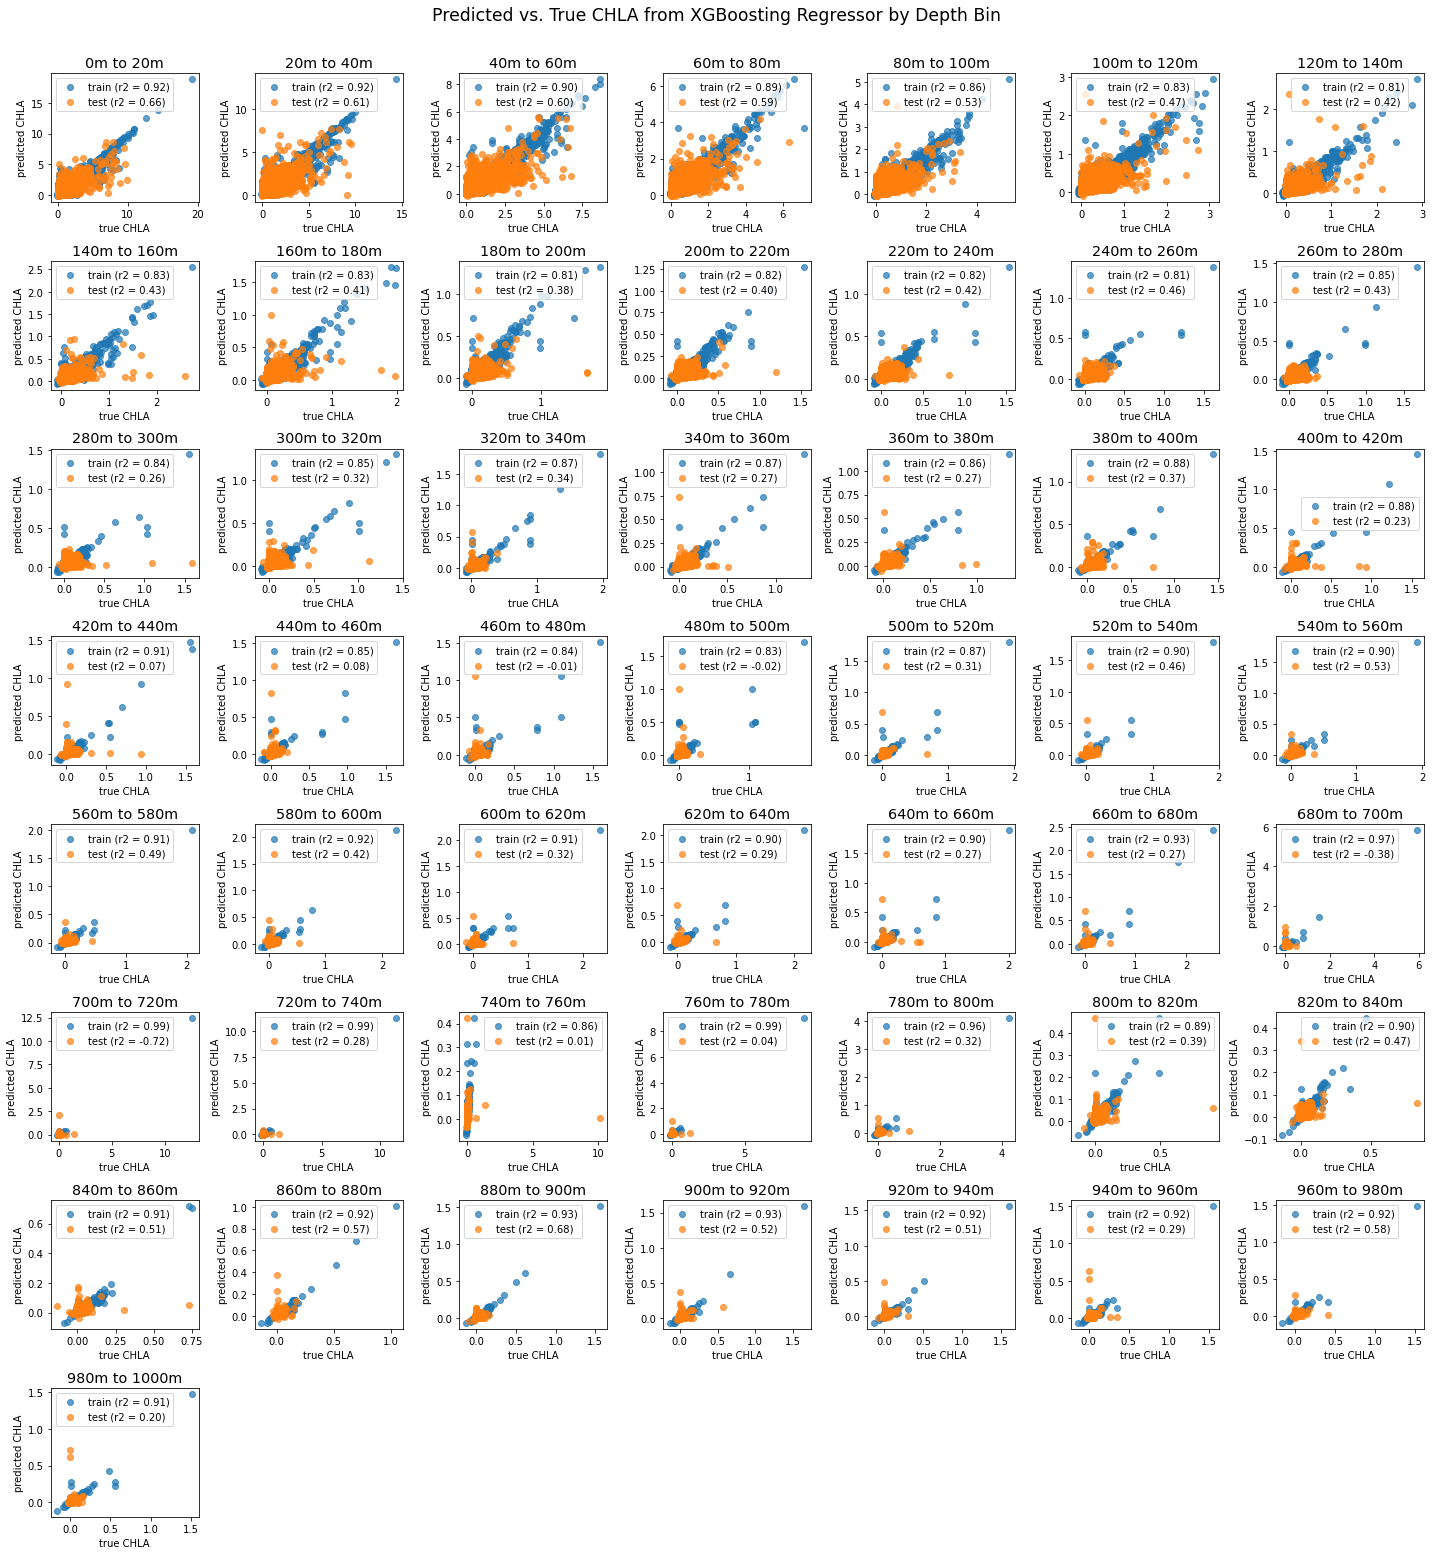

In [18]:
# fit a gradient booting regression model for the ocean at different depth bins
verbose = 1
plt.figure(figsize=(20,22))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin\n\n', fontsize='xx-large')

for depth_idx in range(len(bins)-2):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {bins[depth_idx]}m to {bins[depth_idx+1]}m')
    
    # obtain data for this bin
    data_df = get_data_by_depth(sat_df, float_loc_df, depth_bin=depth_idx)
    
    # train-test-split and standardization
    X_train, X_test, y_train, y_test = split_and_standardize(data_df, test_size=0.2)

    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=100, max_depth=8, colsample_bytree=0.9)     # grow_policy = 'depthwise' or 'lossguide'
    scores = train_and_get_scores(xgbr, X_train, y_train, metrics=['neg_mean_squared_error', 'r2'], n_splits=3, verbose=verbose)
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0:   
        print(f'\tFinal test MSE: {mean_squared_error(y_test, test_preds):.4f}', end='  |  ')
        print(f'Final test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds, plt_n_cols=7)
    
    # add scores to results dataframe
    results_df.loc[results_df.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), data_df.shape[0]] + scores + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


DEPTH 0: 0m to 20m
Num train samples: 38000  |  Num test samples: 9501
Final test MSE: 0.1709  |  Final test r2: 0.6615

DEPTH 1: 20m to 40m
Num train samples: 38000  |  Num test samples: 9500
Final test MSE: 0.1804  |  Final test r2: 0.6162

DEPTH 2: 40m to 60m
Num train samples: 38000  |  Num test samples: 9500
Final test MSE: 0.1068  |  Final test r2: 0.6004

DEPTH 3: 60m to 80m
Num train samples: 38000  |  Num test samples: 9501
Final test MSE: 0.0537  |  Final test r2: 0.5660

DEPTH 4: 80m to 100m
Num train samples: 38000  |  Num test samples: 9501
Final test MSE: 0.0262  |  Final test r2: 0.4997

DEPTH 5: 100m to 120m
Num train samples: 38000  |  Num test samples: 9500
Final test MSE: 0.0131  |  Final test r2: 0.4853

DEPTH 6: 120m to 140m
Num train samples: 38000  |  Num test samples: 9500
Final test MSE: 0.0076  |  Final test r2: 0.4178

DEPTH 7: 140m to 160m
Num train samples: 38000  |  Num test samples: 9501
Final test MSE: 0.0047  |  Final test r2: 0.4398

DEPTH 8: 160m to 1

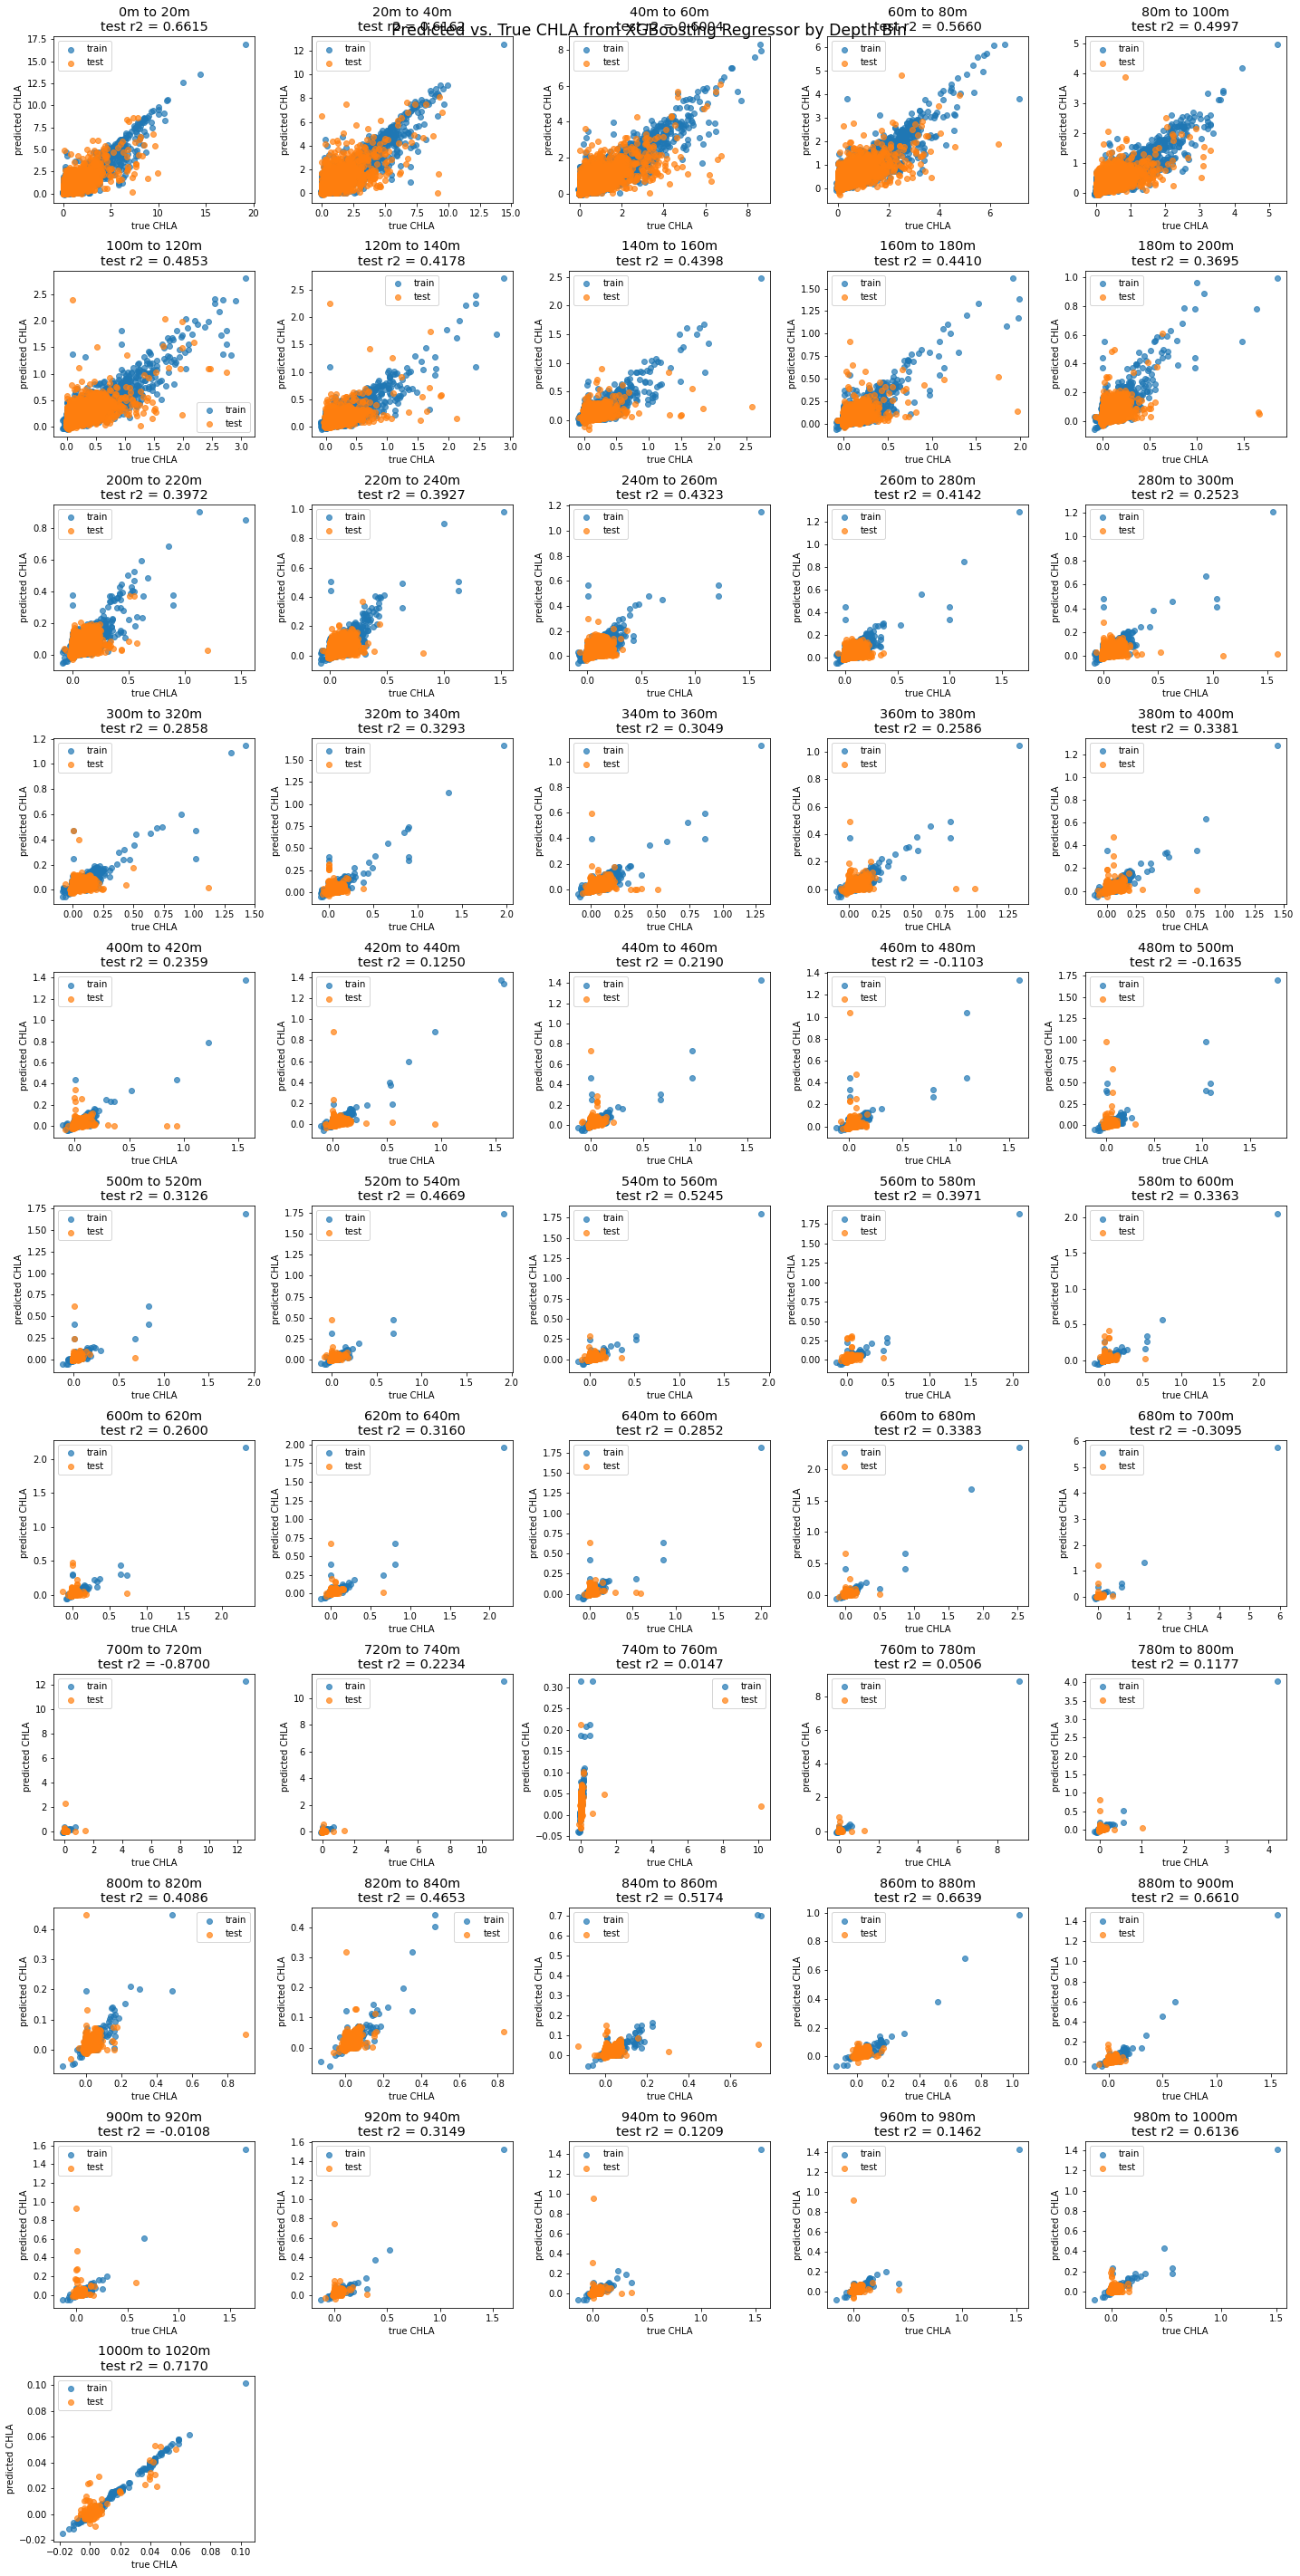

In [193]:
# for comparison: partial results from XGBRegressor() with default hyperparameters and 5-fold cross-validation

## Results: hyperparameter combinations


* n_estimators=150, max_depth=10, grow_policy='lossguide'
    * massively overfit to train data
    * Average cv train r2: 0.96
    * Average final test r2: 0.31
    
    
* n_estimators=150, max_depth=10, colsample_bytree=0.8
    * avg cv test r2 is comperable to final test r2, which is typically slightly improved
    * Average cv train r2: 0.96
    * Average final test r2: 0.34
    
    
* n_estimators=100, max_depth=8, colsample_bytree=0.9
    * still overfit to train data, but not as severly as above; performance similar to default model
    * Average cv train r2: 0.91
    * Average final test r2: 0.34


## Display XGBoost regressor results

In [20]:
# display the dataframe of results
print(f'Average final train r2: {np.mean(results_df["final_train_r2"])}')
print(f'Average final test r2: {np.mean(results_df["final_test_r2"])}')
results_df


Average final train r2: 0.8888950787184338
Average final test r2: 0.3329420698807468


,depth_idx,depth_interval,num_observations,avg_cv_train_mse,avg_cv_train_r2,avg_cv_test_mse,avg_cv_test_r2,final_train_mse,final_train_r2,final_test_mse,final_test_r2
0,0,"(0, 20)",47501,0.030855,0.941509,0.214351,0.593781,0.040503,0.923182,0.169966,0.663382
1,1,"(20, 40)",47500,0.028275,0.940832,0.180957,0.621401,0.037473,0.921576,0.184686,0.607153
2,2,"(40, 60)",47500,0.019861,0.921452,0.106321,0.579502,0.025897,0.897580,0.106755,0.600627
3,3,"(60, 80)",47501,0.011598,0.908302,0.058151,0.540335,0.014465,0.885744,0.050986,0.587945
4,4,"(80, 100)",47501,0.006363,0.891744,0.029966,0.490357,0.008023,0.863698,0.024806,0.526543
5,5,"(100, 120)",47500,0.003382,0.863845,0.015051,0.393929,0.004248,0.829025,0.013435,0.473146
6,6,"(120, 140)",47500,0.001955,0.846314,0.007635,0.401137,0.002451,0.807734,0.007594,0.420589
7,7,"(140, 160)",47501,0.001139,0.855372,0.004301,0.453121,0.001361,0.827417,0.004785,0.434880
8,8,"(160, 180)",47500,0.000650,0.860953,0.002635,0.437777,0.000797,0.829898,0.002974,0.407741
9,9,"(180, 200)",47501,0.000378,0.856185,0.001654,0.371904,0.000498,0.810440,0.001834,0.379332


In [58]:
# display the dataframe of results
print(f'Average final train r2: {np.mean(results_df["final_train_r2"])}')
print(f'Average final test r2: {np.mean(results_df["final_test_r2"])}')
results_df


Average final train r2: 0.8888950787184338
Average final test r2: 0.3329420698807468


,depth_idx,depth_interval,num_observations,avg_cv_train_mse,avg_cv_train_r2,avg_cv_test_mse,avg_cv_test_r2,final_train_mse,final_train_r2,final_test_mse,final_test_r2
0,0,"(0, 20)",47501,0.030855,0.941509,0.214351,0.593781,0.040503,0.923182,0.169966,0.663382
1,1,"(20, 40)",47500,0.028275,0.940832,0.180957,0.621401,0.037473,0.921576,0.184686,0.607153
2,2,"(40, 60)",47500,0.019861,0.921452,0.106321,0.579502,0.025897,0.897580,0.106755,0.600627
3,3,"(60, 80)",47501,0.011598,0.908302,0.058151,0.540335,0.014465,0.885744,0.050986,0.587945
4,4,"(80, 100)",47501,0.006363,0.891744,0.029966,0.490357,0.008023,0.863698,0.024806,0.526543
5,5,"(100, 120)",47500,0.003382,0.863845,0.015051,0.393929,0.004248,0.829025,0.013435,0.473146
6,6,"(120, 140)",47500,0.001955,0.846314,0.007635,0.401137,0.002451,0.807734,0.007594,0.420589
7,7,"(140, 160)",47501,0.001139,0.855372,0.004301,0.453121,0.001361,0.827417,0.004785,0.434880
8,8,"(160, 180)",47500,0.000650,0.860953,0.002635,0.437777,0.000797,0.829898,0.002974,0.407741
9,9,"(180, 200)",47501,0.000378,0.856185,0.001654,0.371904,0.000498,0.810440,0.001834,0.379332


In [19]:
max(results_df['final_test_r2'])

0.6829384215350796

In [48]:
max(results_df['final_test_r2'])

0.6829384215350796

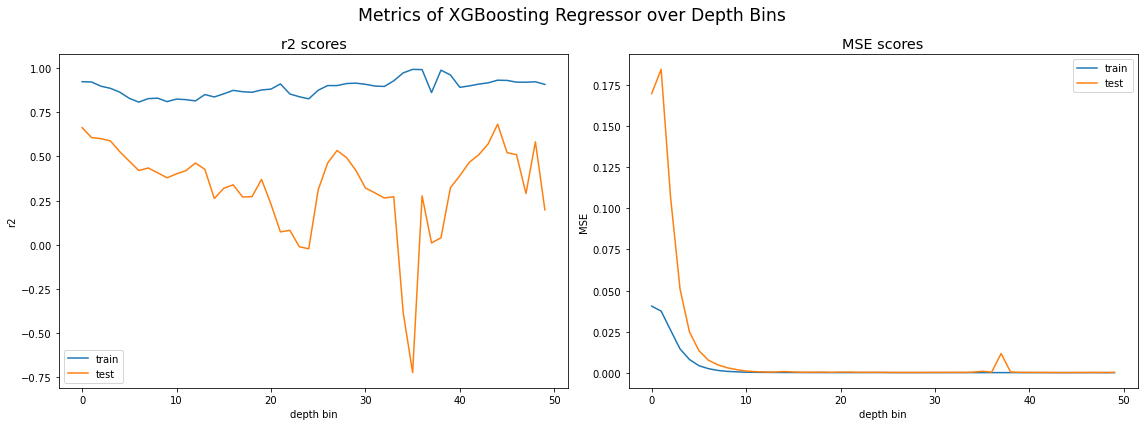

In [21]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df.shape[0]), results_df['final_train_r2'], label='train')
plt.plot(range(results_df.shape[0]), results_df['final_test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df.shape[0]), results_df['final_train_mse'], label='train')
plt.plot(range(results_df.shape[0]), results_df['final_test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [22]:
results_df.to_csv('results_xgb_different_depths_ejd.csv', index=False)


## XGB regressor at surface depths (top 20m at smaller intervals)

In [74]:
# bin the observations into depth intervals
float_loc_df_20 = float_loc_df[float_loc_df['PRES'] <= 20]
try:
    float_loc_df_20.drop(columns='depth_bin', inplace=True)
except:
    pass

max_depth = max(float_loc_df_20['PRES'])
interval = 2
bins = np.arange(0, max_depth + interval, interval)
# bins[-1] = max_depth

depth_bins = pd.cut(float_loc_df_20['PRES'], bins=bins, right=True, labels=False, retbins=False, include_lowest=True)

float_loc_df_20.insert(loc=list(float_loc_df_20.columns).index('PRES'), column='depth_bin', value=depth_bins)
float_loc_df_20


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,float,latitude,longitude,date,date_str,depth_bin,PRES,BBP700,CHLA
0,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,1,3,0.001788,0.695875
1,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,1,4,0.001788,0.695875
2,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,2,6,0.001788,0.696499
3,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,3,8,0.001789,0.716489
4,1902303,49.236,-14.742,2021-05-06 02:03:16,2021-05-06 02:03:16,4,10,0.001790,0.715552
...,...,...,...,...,...,...,...,...,...
33056597,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,7,16,0.000527,0.040150
33056598,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,8,17,0.000534,0.040337
33056599,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,8,18,0.000541,0.040524
33056600,7901001,17.330,-23.271,2022-05-23 11:34:00,2022-05-23 11:34:00,9,19,0.000541,0.040524


In [75]:
# initialize dataframe to store results
results_df_20 = pd.DataFrame(columns=['depth_idx', 'depth_interval', 'num_observations', 'avg_cv_train_mse', 'avg_cv_train_r2', 'avg_cv_test_mse', 'avg_cv_test_r2', 'final_train_mse', 'final_train_r2', 'final_test_mse', 'final_test_r2'])


DEPTH 0: 0m to 2m
	Num train samples: 24711  |  Num test samples: 6178
	Avg train MSE: 0.0213	Avg train r2: 0.9589	Avg val MSE: 0.1929	Avg val r2: 0.6277
	Final test MSE: 0.1910  |  Final test r2: 0.5705

DEPTH 1: 2m to 4m
	Num train samples: 29955  |  Num test samples: 7489
	Avg train MSE: 0.0244	Avg train r2: 0.9522	Avg val MSE: 0.2009	Avg val r2: 0.6069
	Final test MSE: 0.1674  |  Final test r2: 0.6401

DEPTH 2: 4m to 6m
	Num train samples: 37746  |  Num test samples: 9437
	Avg train MSE: 0.0293	Avg train r2: 0.9458	Avg val MSE: 0.2180	Avg val r2: 0.5959
	Final test MSE: 0.1811  |  Final test r2: 0.5943

DEPTH 3: 6m to 8m
	Num train samples: 37851  |  Num test samples: 9463
	Avg train MSE: 0.0288	Avg train r2: 0.9446	Avg val MSE: 0.2163	Avg val r2: 0.5839
	Final test MSE: 0.1945  |  Final test r2: 0.6341

DEPTH 4: 8m to 10m
	Num train samples: 37489  |  Num test samples: 9373
	Avg train MSE: 0.0295	Avg train r2: 0.9444	Avg val MSE: 0.2174	Avg val r2: 0.5894
	Final test MSE: 0.1852  

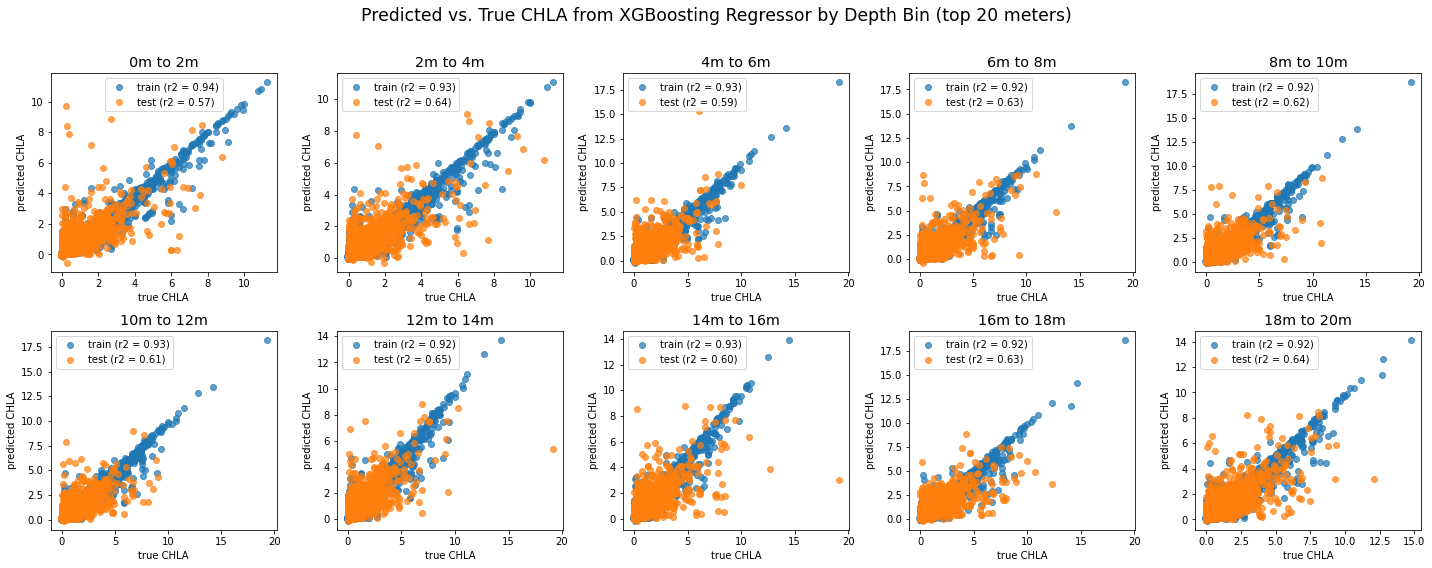

In [76]:
# fit a gradient booting regression model for the surface 20m
verbose = 1
plt.figure(figsize=(20,8))
plt.suptitle('Predicted vs. True CHLA from XGBoosting Regressor by Depth Bin (top 20 meters)\n', fontsize='xx-large')

for depth_idx in range(len(bins)-1):
    
    if verbose > 0:
        print(f'DEPTH {depth_idx}: {bins[depth_idx]}m to {bins[depth_idx+1]}m')
    
    # obtain data for this bin
    data_df = get_data_by_depth(sat_df, float_loc_df_20, depth_bin=depth_idx)
    
    # train-test-split and standardization
    X_train, X_test, y_train, y_test = split_and_standardize(data_df, test_size=0.2)

    if verbose > 0:
        print(f'\tNum train samples: {X_train.shape[0]}', end='  |  ')
        print(f'Num test samples: {X_test.shape[0]}')
    
    # train, predict, and get scores for XGBoosting regressor
    xgbr = XGBRegressor(n_estimators=100, max_depth=8, colsample_bytree=0.9)     # grow_policy = 'depthwise' or 'lossguide'
    scores = train_and_get_scores(xgbr, X_train, y_train, metrics=['neg_mean_squared_error', 'r2'], n_splits=3, verbose=verbose)
    train_preds, test_preds = fit_predict(xgbr, X_train, y_train, X_test, y_test)
    
    if verbose > 0:   
        print(f'\tFinal test MSE: {mean_squared_error(y_test, test_preds):.4f}', end='  |  ')
        print(f'Final test r2: {r2_score(y_test, test_preds):.4f}')
    
    # plot predictions vs. true values
    plot(depth_idx, bins, y_train, train_preds, y_test, test_preds)
    
    # add scores to results dataframe
    results_df_20.loc[results_df_20.shape[0]] = [depth_idx, (bins[depth_idx], bins[depth_idx+1]), data_df.shape[0]] + scores + [mean_squared_error(y_train, train_preds), r2_score(y_train, train_preds), mean_squared_error(y_test, test_preds), r2_score(y_test, test_preds)]
    
    if verbose > 0:
        print()
        
plt.tight_layout()
plt.show()


## Results: hyperparameter combinations


* n_estimators=100, max_depth=8, colsample_bytree=0.9
    * improved test r2 compared to wider depth intervals of the models spanning the whole ocean
    * MSE of train and test are not as disparate as with default XGBRegressor model
    * Average cv train r2: 0.89
    * Average final test r2: 0.51


## Display XGBoost regressor results

In [77]:
# display the dataframe od results
print(f'Average final train r2: {np.mean(results_df_20["final_train_r2"])}')
print(f'Average final test r2: {np.mean(results_df_20["final_test_r2"])}')
results_df_20


Average final train r2: 0.9268842969496799
Average final test r2: 0.6179092262102407


,depth_idx,depth_interval,num_observations,avg_cv_train_mse,avg_cv_train_r2,avg_cv_test_mse,avg_cv_test_r2,final_train_mse,final_train_r2,final_test_mse,final_test_r2
0,0,"(0, 2)",30889,0.021273,0.958937,0.192911,0.627743,0.030241,0.941614,0.190983,0.570545
1,1,"(2, 4)",37444,0.024436,0.952221,0.200915,0.606903,0.035406,0.930961,0.167388,0.640077
2,2,"(4, 6)",47183,0.029289,0.945776,0.218040,0.595908,0.040107,0.925780,0.181124,0.594267
3,3,"(6, 8)",47314,0.028771,0.944550,0.216291,0.583902,0.038952,0.924935,0.194511,0.634059
4,4,"(8, 10)",46862,0.029506,0.944429,0.217421,0.589408,0.042351,0.920473,0.185228,0.617229
5,5,"(10, 12)",45728,0.029075,0.947836,0.231332,0.587326,0.040015,0.928400,0.178782,0.608435
6,6,"(12, 14)",46884,0.030553,0.942760,0.218128,0.592760,0.041478,0.922428,0.188232,0.645034
7,7,"(14, 16)",45219,0.028646,0.946499,0.210734,0.606902,0.037728,0.929575,0.253274,0.600488
8,8,"(16, 18)",47288,0.031070,0.942423,0.211333,0.608940,0.043011,0.920359,0.213934,0.629051
9,9,"(18, 20)",45197,0.029998,0.945121,0.212896,0.610463,0.041406,0.924319,0.212674,0.639908


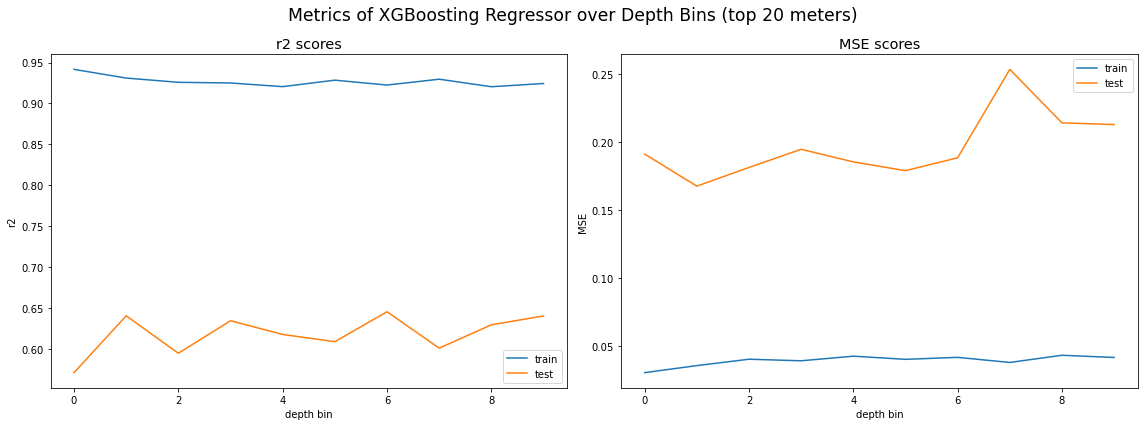

In [78]:
# plot metrics for different depths
plt.figure(figsize=(16,6))
plt.suptitle('Metrics of XGBoosting Regressor over Depth Bins (top 20 meters)', fontsize='xx-large')

plt.subplot(1,2,1)
plt.plot(range(results_df_20.shape[0]), results_df_20['final_train_r2'], label='train')
plt.plot(range(results_df_20.shape[0]), results_df_20['final_test_r2'], label='test')
plt.title('r2 scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('r2')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(results_df_20.shape[0]), results_df_20['final_train_mse'], label='train')
plt.plot(range(results_df_20.shape[0]), results_df_20['final_test_mse'], label='test')
plt.title('MSE scores', fontsize='x-large')
plt.xlabel('depth bin')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


In [79]:
results_df_20.to_csv('results_xgb_different_depths_ejd_20.csv', index=False)
